## Modeling of bank failures by FDIC 

**Instructions:**
- You will be using Python 3.
- Avoid using for-loops and while-loops, unless you are explicitly told to do so.
- Do not modify the (# GRADED FUNCTION [function name]) comment in some cells. Your work would not be graded if you change this. Each cell containing that comment should only contain one function.
- After coding your function, run the cell right below it to check if your result is correct.
- The token generated by Coursera (COURSERA_TOKEN) expires every <b>30 minutes</b>. It is advisable to always work with the most recent generated token so as to avoid any submission related errors. If you receive such error messages, rerun the cells containing your code and the GRADED FUNCTION in the same order. 


## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

In [1]:
import pandas as pd
import numpy as np
import time

import os
import functools
import math
import random
import sys, getopt
import sklearn

sys.path.append("..")
import grading

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass
print('scikit-learn version:', sklearn.__version__)

scikit-learn version: 0.18.2


In [2]:
### ONLY FOR GRADING. DO NOT EDIT ###
submissions=dict()
assignment_key="7VcH6P8REeeRWA42vRAjYg" 
all_parts=["o5YYT", "2cHUA", "Mxrav", "JFNf3", "ivHQa"]
### ONLY FOR GRADING. DO NOT EDIT ###

In [43]:
# token expires every 30 min
COURSERA_TOKEN = "TmZ0ZAOa5wtrv7Bv"# the key provided to the Student under his/her email on submission page
COURSERA_EMAIL = "katsun.chan@georgebrown.ca"# the email

In [6]:
# common cell - share this across notebooks
state_cols = ['log_TA','NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 
              'ALLL_to_TL', 'core_deposits_to_TA', 'brokered_deposits_to_TA', 
              'liquid_assets_to_TA', 'loss_provision_to_TL', 'NIM', 'assets_growth']

all_MEVs = np.array(['term_spread',
                    'stock_mkt_growth',
                    'real_gdp_growth',
                    'unemployment_rate_change',
                    'treasury_yield_3m',
                    'bbb_spread',
                    'bbb_spread_change'])

MEV_cols = all_MEVs.tolist()

next_state_cols = ['log_TA_plus_1Q','NI_to_TA_plus_1Q', 'Equity_to_TA_plus_1Q', 'NPL_to_TL_plus_1Q', 'REO_to_TA_plus_1Q', 
                   'ALLL_to_TL_plus_1Q', 'core_deposits_to_TA_plus_1Q', 'brokered_deposits_to_TA_plus_1Q', 
                   'liquid_assets_to_TA_plus_1Q', 'loss_provision_to_TL_plus_1Q', 
                   'ROA_plus_1Q', 
                   'NIM_plus_1Q', 
                   'assets_growth_plus_1Q', 
                   'FDIC_assessment_base_plus_1Q_n']

In [7]:
df_train = pd.read_hdf('../readonly/df_train_FDIC_defaults_1Y.h5', key='df')
df_test = pd.read_hdf('../readonly/df_test_FDIC_defaults_1Y.h5', key='df')
df_data = pd.read_hdf('../readonly/data_adj_FDIC_small.h5', key='df')
df_closure_learn = pd.read_hdf('../readonly/df_FDIC_learn.h5',key='df')
print(df_closure_learn.index.names)

Opening ../readonly/df_train_FDIC_defaults_1Y.h5 in read-only mode
Opening ../readonly/df_test_FDIC_defaults_1Y.h5 in read-only mode
Opening ../readonly/data_adj_FDIC_small.h5 in read-only mode
Opening ../readonly/df_FDIC_learn.h5 in read-only mode
['IDRSSD', 'date']


## Construct training and testing datasets for logistic regression

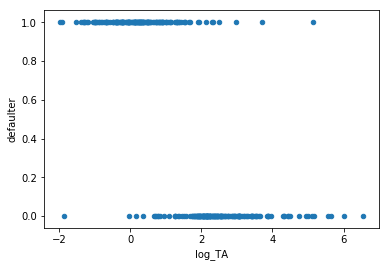

In [8]:
df_test.plot(x=state_cols[0], y='defaulter', kind='scatter')

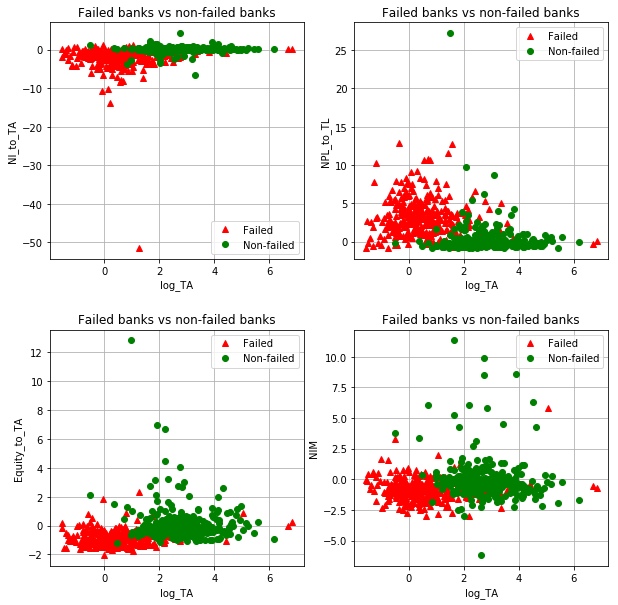

In [9]:
# Plot 4 scatter plots together

# log_TA / NI_to_TA
# log_TA / NPL_to_TL
# log_TA / Equity_to_TA
# log_TA /ROA

first_indx = [0, 0, 0, 0]
second_indx = [1, 3, 2, 10]

X_train = df_train[state_cols].values
y_train = df_train.defaulter.values # .reshape(-1,1)

num_plots = 4
if num_plots % 2 == 0:
    f, axs = plt.subplots(num_plots // 2, 2)
else:
    f, axs = plt.subplots(num_plots// 2 + 1, 2)
    
f.subplots_adjust(hspace=.3)

f.set_figheight(10.0)
f.set_figwidth(10.0)
    
for i in range(num_plots):
    if i % 2 == 0:
        first_idx = i // 2
        second_idx = 0
    else:
        first_idx = i // 2
        second_idx = 1
        
    axs[first_idx,second_idx].plot(X_train[y_train == 1.0, first_indx[i]], 
                                   X_train[y_train == 1.0, second_indx[i]], 'r^', label="Failed")
    axs[first_idx,second_idx].plot(X_train[y_train == 0.0, first_indx[i]], 
                                   X_train[y_train == 0.0, second_indx[i]], 'go',label="Non-failed") 
    
    axs[first_idx, second_idx].legend()
    axs[first_idx, second_idx].set_xlabel('%s' % state_cols[first_indx[i]])
    axs[first_idx, second_idx].set_ylabel('%s' % state_cols[second_indx[i]])
    axs[first_idx, second_idx].set_title('Failed banks vs non-failed banks')
    axs[first_idx, second_idx].grid(True)
    
if num_plots % 2 != 0:
    f.delaxes(axs[i // 2, 1])
    
# plt.savefig('Failed_vs_nonfailed_rr_plot.png')

In [10]:
def calc_metrics(model, df_test, y_true, threshold=0.5):
    """
    Arguments:
    model - trained model such as DecisionTreeClassifier, etc.
    df_test - Data Frame of predictors
    y_true - True binary labels in range {0, 1} or {-1, 1}. If labels are not binary, pos_label should be explicitly given.
    """
    if model is None:
        return 0., 0., 0.
    
    # prediction 
    predicted_sm = model.predict(df_test, linear=False)
    predicted_binary = (predicted_sm > threshold).astype(int)

    # print(predicted_sm.shape, y_true.shape)
    fpr, tpr, _ = metrics.roc_curve(y_true, predicted_sm, pos_label=1)
    
    # compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    roc_auc = metrics.auc(fpr, tpr)
    ks = np.max(tpr - fpr) # Kolmogorov - Smirnov test

    # note that here teY[:,0] is the same as df_test.default_within_1Y
    accuracy_score = metrics.accuracy_score(y_true, predicted_binary)
    
    # equivalently, Area Under the ROC Curve could be computed as:
    # compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    # auc_score = metrics.roc_auc_score(y_true, predicted_sm)

    try:
        plt.title('Logistic Regression ROC curve')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')

        # plt.savefig('ROC_curve_1.png')
        plt.show()
    except:
        pass

    return roc_auc, accuracy_score, ks

In [11]:
def make_test_train(df_train, df_test, choice=0, predict_within_1Y=False):
    """
    make the train and test datasets
    Arguments:
    choice - an integer 0 or -1. Controls selection of predictors. 
    Add tangible equity and assessment base as predictors

    predict_within_1Y - boolean  if True, predict defaults within one year
    Return:
        a tuple of:
        - training data set predictors, np.array
        - training data set : variable to predict, np.array
        - test data set : variable to predict, np.array
        - predictor variable names
    """
    
    if choice == -1: # only state cols
        predictors = state_cols
    elif choice == 0:  # original variables
        predictors = state_cols + MEV_cols 

    trX = df_train[predictors].values
    teX = df_test[predictors].values
    num_features = len(predictors)    
    num_classes = 2

    if predict_within_1Y == True:
        trY = df_train[['default_within_1Y','no_default_within_1Y']].values
        teY = df_test[['default_within_1Y','no_default_within_1Y']].values
    else:
        trY = df_train[['defaulter','non_defaulter']].values
        teY = df_test[['defaulter','non_defaulter']].values
    return trX, trY, teX, teY, predictors

In [12]:
# look at correlations
df_train[MEV_cols].corr()

,term_spread,stock_mkt_growth,real_gdp_growth,unemployment_rate_change,treasury_yield_3m,bbb_spread,bbb_spread_change
term_spread,1.000000,0.002993,-0.145941,0.299972,-0.633991,0.392349,-0.465767
stock_mkt_growth,0.002993,1.000000,-0.148941,0.461947,-0.081915,0.417379,-0.762702
real_gdp_growth,-0.145941,-0.148941,1.000000,-0.825802,0.041596,-0.820518,0.385007
unemployment_rate_change,0.299972,0.461947,-0.825802,1.000000,0.034355,0.881223,-0.657093
treasury_yield_3m,-0.633991,-0.081915,0.041596,0.034355,1.000000,-0.272072,0.290414
bbb_spread,0.392349,0.417379,-0.820518,0.881223,-0.272072,1.000000,-0.716249
bbb_spread_change,-0.465767,-0.762702,0.385007,-0.657093,0.290414,-0.716249,1.000000


## Logistic regression with statsmodels

### Part 1
Perform logistic regression using **cols_to_use** as predictors. Use df_train pandas DataFrame as training data set, and df_test pandas DataDrame as testing data set to perform prediction based on the already trained model. Utilize statsmodels package. The result of fitting logistic regression should be assigned to variable named **model**

In [13]:
import statsmodels.api as sm
from sklearn import metrics

cols_to_use = state_cols + MEV_cols  + ['const']
model = None
df_train['const'] = 1

### START CODE HERE ### (≈ 3 lines of code)
# ....
logit = sm.Logit(df_train['defaulter'], df_train[cols_to_use])
model = logit.fit()
### END CODE HERE ###

Optimization terminated successfully.
         Current function value: 0.159379
         Iterations 9


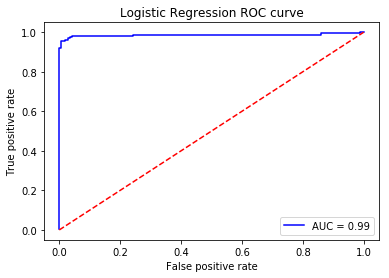

Accuracy score 0.969789
AUC score 0.986043
Kolmogorov-Smirnov statistic 0.950639


In [14]:
# prediction 
predicted_sm = np.array([])

### START CODE HERE ### (≈ 3 lines of code)
predicted_sm = model.predict(df_test[cols_to_use])
### END CODE HERE ###

threshold = 0.5
predicted_binary = (predicted_sm > threshold).astype(int)
auc_score, accuracy_score, ks = calc_metrics(model, df_test[cols_to_use], df_test.defaulter)

print('Accuracy score %f' % accuracy_score)
print('AUC score %f' % auc_score)
print('Kolmogorov-Smirnov statistic %f' % ks)

# note that here teY[:,0] is the same as df_test.default_within_1Y

In [15]:
### GRADED PART (DO NOT EDIT) ###
part_1=[accuracy_score, auc_score, ks]

try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)    
    
submissions[all_parts[0]]=part1
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[0],all_parts,submissions)
[accuracy_score, auc_score, ks]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


[0.96978851963746227, 0.98604311289733282, 0.95063938618925836]

## Logistic Regression with sklearn

### Part 2 
In Part 2 you will use scikit-learn to perform logistic regression using the same training and test datasets.
Once the model is trained using trX, thisTrY, test it using teX, thisTeY and compute logistic regression score.

- Use **"l1"** penalty
- Set inverse of regularization strength to **1000.0**; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- Set tolerance to **1e-6**

In [24]:
from sklearn import neighbors, linear_model

trX, trY, teX, teY, predictors = make_test_train(df_train, df_test)
lr_score = 0.
thisTrY = trY[:,0]
thisTeY = teY[:,0]

logistic = None # instantiate a model and reference it
result = None # result of fitting the model

### START CODE HERE ### (≈ 3 lines of code)
# .... define random_state argment in logistic regression class. Ininitialize it to 42
# such as this: random_state=42
# the variable name required for grading lr_score

logistic = linear_model.LogisticRegression(penalty='l1', tol=0.000001, C=1000, random_state=42)
result = logistic.fit(trX, thisTrY)
lr_score = logistic.score(teX, thisTeY)

### END CODE HERE ###
print('LogisticRegression score: %f' % lr_score)

LogisticRegression score: 0.969789


In [25]:
### GRADED PART (DO NOT EDIT) ###
part2=str(lr_score)   
submissions[all_parts[1]]=part2
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:2],all_parts,submissions)
lr_score
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


0.96978851963746227

**Instructions:**
In this part you will again use scikit learn logistic regression but with different set of predictors. This will be a smaller set of predictor variables based on the analysis of P-values from the logistic regression. Use cols_to_use as predictors in df_train and df_test data sets. Use  **defaulter** column as something to predict.

Initialize reference to the logistic regression model **logistic** with an instance of appropriate class from  scikit learn module and let **result** be the result of fitting the model to the training data set.

Just as before initialize the model with the following parameters:
- Use **"l1"** penalty
- Set inverse of regularization strength to **1000.0**; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- Set tolerance to **1e-6**

In [26]:
# Do Logistic Regression with a smaller number of predictor, based on analysis of P-values 
# for the logistic regression with a full set of variables

# a smaller set is based on the analysis of P-values for the logistic regression
cols_to_use = ['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL',
               'core_deposits_to_TA',
               'brokered_deposits_to_TA',
               'liquid_assets_to_TA'
              ] + ['term_spread', 'stock_mkt_growth']

lr_score = 0.
logistic = None
result = None
### START CODE HERE ### (≈ 3 lines of code)
# .... when initializing logistic regression class in 'sklearn', set random_state to 42 like this: random_state=42
# ... like this: random_state=42
# ... for grading, please store the logistic regression model into variable : logistic

logistic = linear_model.LogisticRegression(penalty='l1', tol=0.000001, C=1000, random_state=42)
result = logistic.fit(df_train[cols_to_use], df_train['defaulter'])

### END CODE HERE ###

# combine results of the Logistic Regression to a small dataframe df_coeffs_LR
df_coeffs_LR = pd.DataFrame({0: np.array([0.] * (len(cols_to_use) + 1), dtype=np.float32)})
if logistic is not None:
    model_params = np.hstack((logistic.coef_[0], logistic.intercept_))
    df_coeffs_LR = pd.DataFrame(data=model_params, index=cols_to_use + ['const'])
    df_coeffs_LR

In [27]:
### GRADED PART (DO NOT EDIT) ###
part_3=list(df_coeffs_LR.values.squeeze())
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)    
submissions[all_parts[2]]=part3
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:3],all_parts,submissions)
df_coeffs_LR.values.squeeze()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([-1.47322995, -0.79712207, -1.88434794,  0.33807849, -0.50266831,
        0.02356076, -0.5134171 ,  0.01134757,  0.02644036, -0.09384567])

## Logistic Regression with Tensorflow

In [28]:
# Setup inputs and expeced outputs for Logistic Regression using Tensorflow
cols = state_cols + MEV_cols
# inputs to Logistic Regression (via Tensorflow)
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# add constant columns to both
X_trainTf = np.hstack((np.ones((X_trainTf.shape[0], 1)), X_trainTf))
X_testTf = np.hstack((np.ones((X_testTf.shape[0], 1)), X_testTf))

# exepectd outputs:
y_trainTf = df_train.defaulter.astype('int').values.reshape(-1,1)
y_testTf = df_test.defaulter.astype('int').values.reshape(-1,1)

In [29]:
print('Unique values to predict:', np.unique(y_trainTf))
print('Number of samples to train on:', y_trainTf.shape[0])
print('Number of samples to test on:', y_testTf.shape[0])

Unique values to predict: [0 1]
Number of samples to train on: 641
Number of samples to test on: 331


In [30]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [31]:
def random_batch(X_train, y_train, batch_size):
    np.random.seed(42)
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

### Build Logistic Regression TF model

**instructions**

in tensorflow create: 
 - placeholder for inputs called 'X' 
 - placeholder for inputs called 'y'
 - variable for model parameters called 'theta', initialized with theta_init

loss function: use log loss
optimizer: use Gradient Descent optimizer

In [54]:
import tensorflow as tf

# define the model
reset_graph()
n_inputs = X_trainTf.shape[1]
learning_rate = 0.01
theta_init = tf.random_uniform([n_inputs, 1], -1.0, 1.0, seed=42)

# build Logistic Regression model using Tensorflow

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(theta_init, name="theta")

### START CODE HERE ### (≈ 6-7 lines of code)
### ....
### .... for grading please store probabilities in y_proba

logits = tf.matmul(X, theta)
y_proba = tf.sigmoid(logits)

epsilon = 1e-7
loss = tf.losses.log_loss(y, y_proba, epsilon=epsilon)
model_train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

# uses epsilon = 1e-7 by default to regularize the log function

### END CODE HERE ###

init = tf.global_variables_initializer()


### Train Logistic Regression TF model

**Instructions**
- Use random_batch() function to grab batches from X_trainTf and y_trainTf.
- Once the model is trained evaluate it based on X_testTf and y_testTf. 
- The **y_proba_val** should be assigned the result of the evaluation on test dataset.

In [71]:
n_epochs = 1001
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))

y_proba_val = np.array([], dtype=np.float32)

with tf.Session() as sess:
    sess.run(init)

    ### START CODE HERE ### (≈ 6-7 lines of code)
    ## ....
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_trainTf, y_trainTf, batch_size)
            sess.run([model_train, loss], feed_dict={X:X_batch, y:y_batch})   
    y_proba_val = sess.run(y_proba, feed_dict={X:X_testTf})
    ### END CODE HERE ###

In [72]:
# predictions
threshold = 0.5
y_pred = (y_proba_val >= threshold)
print(np.sum(y_pred))

149


In [73]:
y_pred.squeeze()

array([ True, False, False,  True,  True,  True, False,  True, False,
        True, False,  True, False, False, False,  True, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False, False, False, False,  True,  True,  True, False,  True,
       False,  True, False, False, False,  True,  True,  True, False,
        True,  True,  True, False,  True, False,  True, False,  True,
       False, False, False, False,  True, False,  True,  True,  True,
        True, False,  True, False, False,  True, False, False,  True,
       False, False,  True, False, False,  True, False,  True,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
        True, False,  True, False,  True, False,  True,  True, False,
        True, False, False,  True,  True, False,  True, False, False,
       False, False,

precision:  0.979865771812
recall:  0.906832298137
AUC score =  0.982243332115
roc_auc =  0.982243332115
KS_test =  0.927438801608


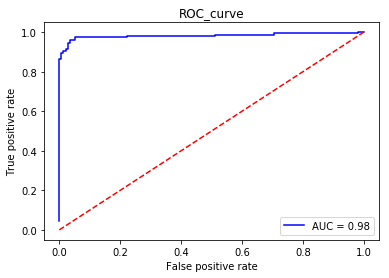

In [74]:
# evaluate precision, recall, and AUC

auc_score = 0.
ks = 0.
roc_auc = 0.
recall = 0.
precision = 0.

from sklearn.metrics import precision_score, recall_score
if y_proba_val.shape == y_testTf.shape:
    precision = precision_score(y_testTf, y_pred)
    recall = recall_score(y_testTf, y_pred)
    auc_score = metrics.roc_auc_score(y_testTf, y_proba_val)
    fpr, tpr, threshold = metrics.roc_curve(y_testTf, y_proba_val, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    ks = np.max(tpr - fpr)

    print('precision: ', precision)
    print('recall: ', recall)
    print('AUC score = ', auc_score)
    print('roc_auc = ', roc_auc)
    print('KS_test = ', ks)

    try:
        plt.title('ROC_curve')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.savefig('ROC_curve_TF.png')
        plt.show()
    except:
        pass

In [75]:
### GRADED PART (DO NOT EDIT) ###
part_4=list([precision, recall, roc_auc, ks])
try:
    part4 = " ".join(map(repr, part_4))
except TypeError:
    part4 = repr(part_4)
submissions[all_parts[3]]=part4
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:4],all_parts,submissions)
[precision, recall, roc_auc, ks]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


[0.97986577181208057,
 0.90683229813664601,
 0.98224333211545489,
 0.92743880160759962]

## Neural Network with Tensorflow

In [76]:
cols = state_cols + MEV_cols
n_inputs = len(cols)

# inputs 
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# outputs 
y_trainTf = df_train['defaulter'].astype('int').values.reshape(-1,)
y_testTf = df_test['defaulter'].astype('int').values.reshape(-1,)

In [77]:
import numpy as np
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        tf.set_random_seed(42)
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

### Construct Neural Network

**Instructions**
Implement Neural Network with two hidden layers. The number of nodes in the first and the second hidden layers is **n_hidden1** and **n_hidden2** correspondingly.
Use neuron_layer() function to construct neural network layers.

- Use ReLU activation function for hidden layers
- The output layer has **n_outputs** and does not have an activation function
- Use sparse softmax cross-entropy with logits as a loss function

In [81]:
n_hidden1 = 20
n_hidden2 = 10
n_outputs = 2 # binary classification (defaulted, not defaulted bank)

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

### START CODE HERE ### (≈ 10-15 lines of code)
### ...
h1 = neuron_layer(X, n_hidden1, 'h1', activation=tf.nn.relu)
h2 = neuron_layer(h1, n_hidden2, 'h2', activation=tf.nn.relu)
out = neuron_layer(h2, n_outputs, 'output')

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=out, labels=y))
### END CODE HERE ###

init = tf.global_variables_initializer()

### Train Neural Network

**Instructions**
Train neural network passing batches of inputs of size **batch_size**, which predicts bank defaults / non-defaults. Once the network is trained, evaluate accuracy using **X_testTf**, **y_testTf**


In [86]:
learning_rate = 0.05
n_epochs = 400
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))
acc_test = 0. #  assign the result of accuracy testing to this variable

### START CODE HERE ### (≈ 9-10 lines of code)
# ... variable required for testing acc_test
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
with tf.Session() as sess:
    sess.run(init)    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_trainTf, y_trainTf, batch_size)
            sess.run([optimizer, loss], feed_dict={X:X_batch, y:y_batch}) 
            
    output = sess.run(out, feed_dict={X:X_testTf, y:y_testTf})
    preds = tf.nn.softmax(output)
    correct_preds = tf.equal(tf.argmax(preds, 1), y_testTf)
    acc_test = sess.run(tf.reduce_sum(tf.cast(correct_preds, tf.float32))) / len(y_testTf)
### END CODE HERE ###

In [84]:
### GRADED PART (DO NOT EDIT) ###
part5=str(acc_test)
submissions[all_parts[4]]=part5
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:5],all_parts,submissions)
acc_test
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


0.9214501510574018